In [1]:
import math
import time
from google.colab import files

In [2]:
def get_coordinates_for_vector(vector, min):
  # using value of each part of vector as distance, equally spacing around a point
  # just complicated by presence of negative values, will probably bump everything up by minimum of whole dataset for now
  angle = 360 / len(vector)
  points = []
  for c,v in enumerate(vector):
    x = (v + min) * math.cos(angle*c)
    y = (v + min) * math.sin(angle*c)
    points.append([x, y])

  return points

In [ ]:
# thinking atm can just write these to a file, load in to js? or have this calculation within js? depending on whether can load vecs straight into js or how would work

In [3]:
import gensim
from gensim.models import Word2Vec

model = Word2Vec.load("scpword2vec.model")

print(model.most_similar('containment'))

[('site', 0.5707194209098816), ('containment_measures', 0.5412185192108154), ('research', 0.5396344661712646), ('containment_protocols', 0.5285018086433411), ('testing', 0.521632969379425), ('personnel', 0.5118201375007629), ('recontainment', 0.5112651586532593), ('foundation', 0.4936738908290863), ('quarantine', 0.48947620391845703), ('site_56', 0.4806642234325409)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


In [4]:
from itertools import chain

model_min = abs(min(chain.from_iterable(model.wv['{}'.format(i)] for i in list(model.wv.vocab))))
print(model_min)

3.7692266


In [ ]:
sample_vector = model.wv['containment']

In [ ]:
print(len(sample_vector))

300


In [ ]:
sample_vector_points = get_coordinates_for_vector(sample_vector, model_min)

In [5]:
def generate_coords_all_words(model, min):
  all_word_coords = {}
  vocab = list(model.wv.vocab)
  for i in vocab:
    all_word_coords[i] = get_coordinates_for_vector(model.wv['{}'.format(i)], min)
  return all_word_coords

In [33]:
import json

def save_json(filename, data):
  with open(filename + '.json', 'w') as file_:
    json.dump(data, file_, ensure_ascii=False)
  time.sleep(200)
  files.download(filename + ".json")

In [6]:
coordinates_all_words = generate_coords_all_words(model, model_min)

In [ ]:
save_json("scp_wordvec_keyval_coords", coordinates_all_words)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# save co-ords to file - prob just txt atm but can save as variable and make it a py, js, json etc file lol
def save_coords(filename, coords):
  file_ = open(filename + ".txt", "w")
  file_.write(str(coords))
  file_.close()
  time.sleep(350)
  files.download(filename + ".txt")

In [ ]:
save_coords("scp_wordvec_coords", coordinates_all_words)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(sample_vector_points)

[[3.6693825721740723, 0.0], [1.338576674456038, 3.443022164542551], [-2.779932275327333, 2.5464576885241548], [-3.2857371930951893, -1.6214019882664576], [0.2888507394805857, -3.2885283073688876], [3.093598730530522, -0.900256384244382], [2.0512638766542906, 2.6761218070628887], [-1.776824978958511, 2.924139926501688], [-3.4279160032555893, -0.6068700447903422], [-0.5432963807814428, -2.7424451197119497], [2.2871669698562713, -1.4543178262899323], [2.7019130793752684, 1.9850639266017747], [-1.06381264229246, 3.9538503731675165], [-4.220648457911689, 0.4574537536266861], [-1.7771149148500383, -3.4238808931191764], [2.2274060992606786, -2.5332594996337683], [2.8374822138081637, 1.0371900562921594], [0.09198656838603304, 4.5191010751709415], [-3.312451086690946, 1.3660488504380686], [-2.0036855335854713, -2.099946744717611], [1.789394144095433, -3.820171649151889], [3.52685062225701, 0.2375699825586394], [1.0134746580725849, 3.235699344997853], [-3.4824738301648352, 2.7836549970066815], [

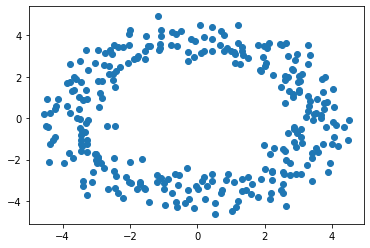

300


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [i[0] for i in sample_vector_points]
y = [i[1] for i in sample_vector_points]

plt.scatter(x, y)
plt.show()
print(len(x))

In [29]:
# probs need to scale up, try dynamically? 
# also gonna define something to make the list of tuples/lists into the format that could go more straight into svg
# aaaalso need to handle negatives maybe shift by min for x and y respectively
# although for sake of comparisons best to do dataset minimum as above
def make_svg_friendly(points, min_=None):
  if not min_:
    min_x = min([i[0] for i in points])
    min_y = min([i[1] for i in points])
    # can do overall min and add
    padding = abs(min([min_x, min_y]) * 1.5)
  else:
    padding = abs(min_ * 1.5)
  point_str = ""
  for point in points:
    point_str += ",".join([str(point[0] +padding), str(point[1] + padding)]) + " "
  return point_str.rstrip()

In [26]:
from itertools import chain

# coordinates_all_words is dict with nested list values, want the smallest value from all, and can disregard keys
all_x_coords = []
all_y_coords = []

for i in list(coordinates_all_words.values()):
  all_x_coords.append([j[0] for j in i])
  all_y_coords.append([j[1] for j in i])

all_x_coords = list(chain.from_iterable(all_x_coords))
all_y_coords = list(chain.from_iterable(all_y_coords))

# print(all_x_coords[:100])

svg_min = abs(min([min(all_y_coords), min(all_x_coords)]))
print(svg_min)

8.082082832291242


In [ ]:
print(make_svg_friendly(sample_vector_points))

10.604851448289628,6.935468876115555 8.274045550571593,10.378491040658107 4.155536600788222,9.48192656463971 3.649731683020366,5.314066887849098 7.224319615596141,3.646940568746668 10.029067606646077,6.035212491871174 8.986732752769846,9.611590683178445 5.158643897157044,9.859608802617243 3.507552872859966,6.3285988313252135 6.392172495334113,4.193023756403606 9.222635845971826,5.481151049825623 9.637381955490824,8.92053280271733 5.871656233823096,10.889319249283073 2.7148204182038667,7.392922629742242 5.158353961265517,3.511587982996379 9.162874975376234,4.402209376481787 9.772951089923719,7.972658932407715 7.027455444501588,11.454569951286498 3.6230177894246096,8.301517726553623 4.931783342530084,4.835522131397944 8.72486302021099,3.1152972269636665 10.462319498372565,7.173038858674195 7.948943534188141,10.171168221113408 3.45299504595072,9.719123873122237 3.923092873001275,5.187959362957382 7.3573652945699335,4.233082585236396 10.985051892682637,6.0472085127359465 8.892160015412552,

In [30]:
def make_all_svg_polygon_strings(all_coords, offset): # all coords should be dict with word key and coordinate value as made above
  svg_dict = {}
  for k,v in all_coords.items():
    svg_dict[k] = make_svg_friendly(v, offset)
  return svg_dict

In [31]:
polygon_str_dict = make_all_svg_polygon_strings(coordinates_all_words, svg_min)

In [34]:
save_json( "scp_word_polygon_keyvals", polygon_str_dict)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>